# Amsterdam Weather Analysis - KNMI Data

Analysis of 10 years of hourly weather data from KNMI (Royal Netherlands Meteorological Institute).
Data is in UTC with proper timezone handling.

**Features:**
- Temperature (°C) at 1.50m height
- Wind speed (m/s) 10-minute average  
- Global horizontal irradiance (W/m²) hourly

**Analysis:**
1. Hourly model with daily/annual cycles
2. Daily model with annual cycles
3. Pairwise joint distributions


In [54]:
import matplotlib
matplotlib.use('module://matplotlib_inline.backend_inline')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from cgmm import ConditionalGMMRegressor
import warnings
import os
warnings.filterwarnings('ignore')

# Set style
plt.style.use('default')
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 10

# Colors
colors = {'temp': '#e74c3c', 'wind': '#3498db', 'light': '#f1c40f'}

os.makedirs('gallery_images', exist_ok=True)

## Load and Prepare Data


In [48]:
# Load data
df = pd.read_csv('data/amsterdam_knmi_hourly.csv')
df['datetime'] = pd.to_datetime(df['datetime'])
df = df.set_index('datetime')

# add a biut of noise to eliminate discretuztion artifacts

df['wind_ms_log1p'] = np.log1p(df['wind_ms'])
df['ghi_wm2_log1p'] = np.log1p(df['ghi_wm2'])


print(f"Data: {len(df):,} records from {df.index.min()} to {df.index.max()}")
print(f"Columns: {list(df.columns)} (wind_ms and ghi_wm2 log1p transformed)")
df.head()


Data: 96,432 records from 2014-01-01 00:00:00 to 2024-12-31 23:00:00
Columns: ['temp_c', 'wind_ms', 'ghi_wm2', 'wind_ms_log1p', 'ghi_wm2_log1p'] (wind_ms and ghi_wm2 log1p transformed)


,temp_c,wind_ms,ghi_wm2,wind_ms_log1p,ghi_wm2_log1p
datetime,,,,,
2014-01-01 00:00:00,6.2,7.0,0.0,2.079442,0.0
2014-01-01 01:00:00,5.6,6.0,0.0,1.945910,0.0
2014-01-01 02:00:00,6.2,6.0,0.0,1.945910,0.0
2014-01-01 03:00:00,5.2,6.0,0.0,1.945910,0.0
2014-01-01 04:00:00,4.9,6.0,0.0,1.945910,0.0


## Hourly Model with Daily/Annual Cycles


In [49]:
# Create cyclical features
df['hour'] = df.index.hour
df['day_of_year'] = df.index.dayofyear

# Daily cycles
df['daily_sin'] = np.sin(2 * np.pi * df['hour'] / 24)
df['daily_cos'] = np.cos(2 * np.pi * df['hour'] / 24)

# Annual cycles
df['annual_sin'] = np.sin(2 * np.pi * df['day_of_year'] / 365.25)
df['annual_cos'] = np.cos(2 * np.pi * df['day_of_year'] / 365.25)

# Prepare data
X_hourly = df[['daily_sin', 'daily_cos', 'annual_sin', 'annual_cos']].values
y_hourly = df[['temp_c', 'wind_ms_log1p', 'ghi_wm2_log1p']].values

print(f"Features: {X_hourly.shape[1]}, Targets: {y_hourly.shape[1]}")


Features: 4, Targets: 3


In [50]:
# Fit hourly model
model_hourly = ConditionalGMMRegressor(n_components=5, random_state=42)
model_hourly.fit(X_hourly, y_hourly)
print(f"Hourly model fitted: {model_hourly.n_components} components")


Hourly model fitted: 5 components


## Hourly Predictions and Plots (2023-2024)


In [51]:
# Get first week of September 2024
mask_sep = (df.index.year == 2024) & (df.index.month == 9) & (df.index.day <= 7)
df_plot = df[mask_sep].copy()
X_plot = X_hourly[mask_sep]
y_plot = y_hourly[mask_sep]

# Generate samples
n_samples = 1000
samples = model_hourly.sample(X_plot, n_samples=n_samples)

samples[:,:,1] = np.exp(samples[:,:,1]) - 1
samples[:,:,2] = np.exp(samples[:,:,2]) - 1

# Calculate percentiles
percentiles = np.percentile(samples, [5, 50, 95], axis=1)
p5, p50, p95 = percentiles[0], percentiles[1], percentiles[2]

print(f"Generated {samples.shape[1]} samples for {len(df_plot)} time points (Sep 1-7, 2024)")

Generated 1000 samples for 168 time points (Sep 1-7, 2024)


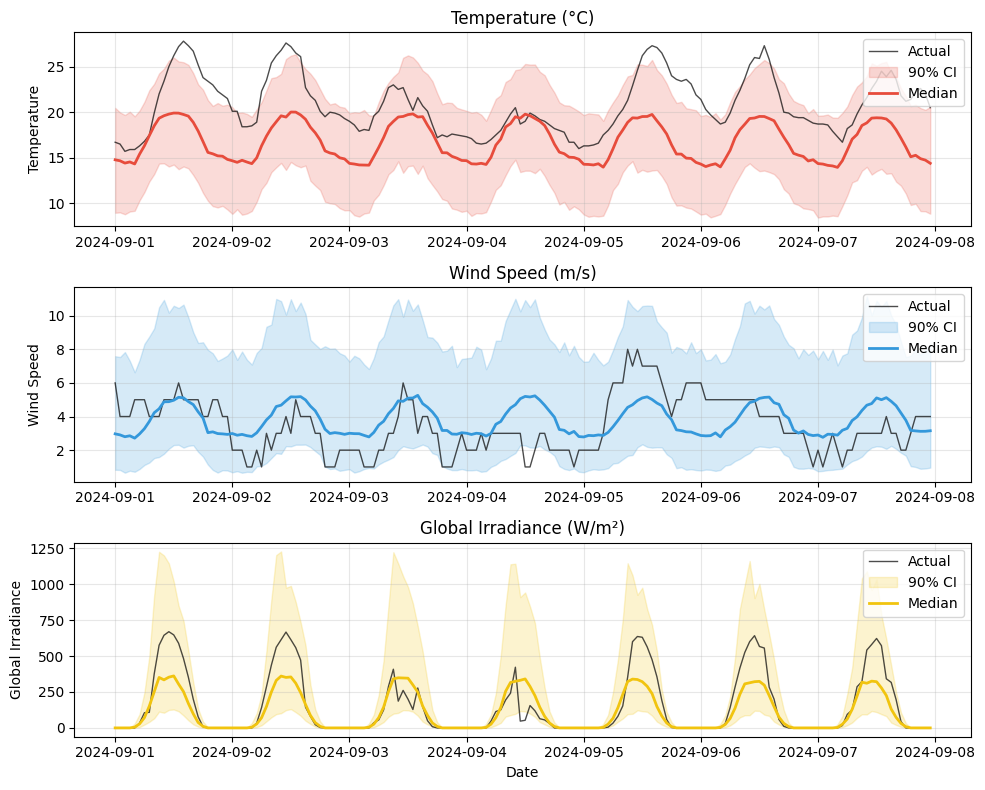

In [55]:
# Plot hourly predictions
fig, axes = plt.subplots(3, 1, figsize=(10, 8))
variables = ['temp_c', 'wind_ms', 'ghi_wm2']
titles = ['Temperature (°C)', 'Wind Speed (m/s)', 'Global Irradiance (W/m²)']
var_colors = [colors['temp'], colors['wind'], colors['light']]

for i, (var, title, color) in enumerate(zip(variables, titles, var_colors)):
    ax = axes[i]
    
    # Actual data
    ax.plot(df_plot.index, df_plot[var], 'k-', alpha=0.7, linewidth=1, label='Actual')
    
    # Model percentiles
    ax.fill_between(df_plot.index, p5[:, i], p95[:, i], alpha=0.2, color=color, label='90% CI')
    ax.plot(df_plot.index, p50[:, i], '-', color=color, linewidth=2, label='Median')
    
    ax.set_title(title)
    ax.set_ylabel(title.split('(')[0].strip())
    ax.legend(loc='upper right')
    ax.grid(True, alpha=0.3)
    
    if i == 2:
        ax.set_xlabel('Date')

plt.tight_layout()
plt.savefig('gallery_images/weather_hourly.png', dpi=150, bbox_inches='tight')

plt.show()


## Hourly Pairwise Distributions (2024)


In [7]:
# Get 2024 data
mask_2024 = df.index.year == 2024
df_2024 = df[mask_2024]
X_2024 = X_hourly[mask_2024]
y_2024 = y_hourly[mask_2024]

# Generate samples for 2024
samples_2024 = model_hourly.sample(X_2024, n_samples=n_samples)

# Flatten samples for plotting
samples_flat = samples_2024.reshape(-1, 3)

print(f"2024 data: {len(df_2024)} records, {samples_flat.shape[0]} samples")


2024 data: 8784 records, 8784000 samples


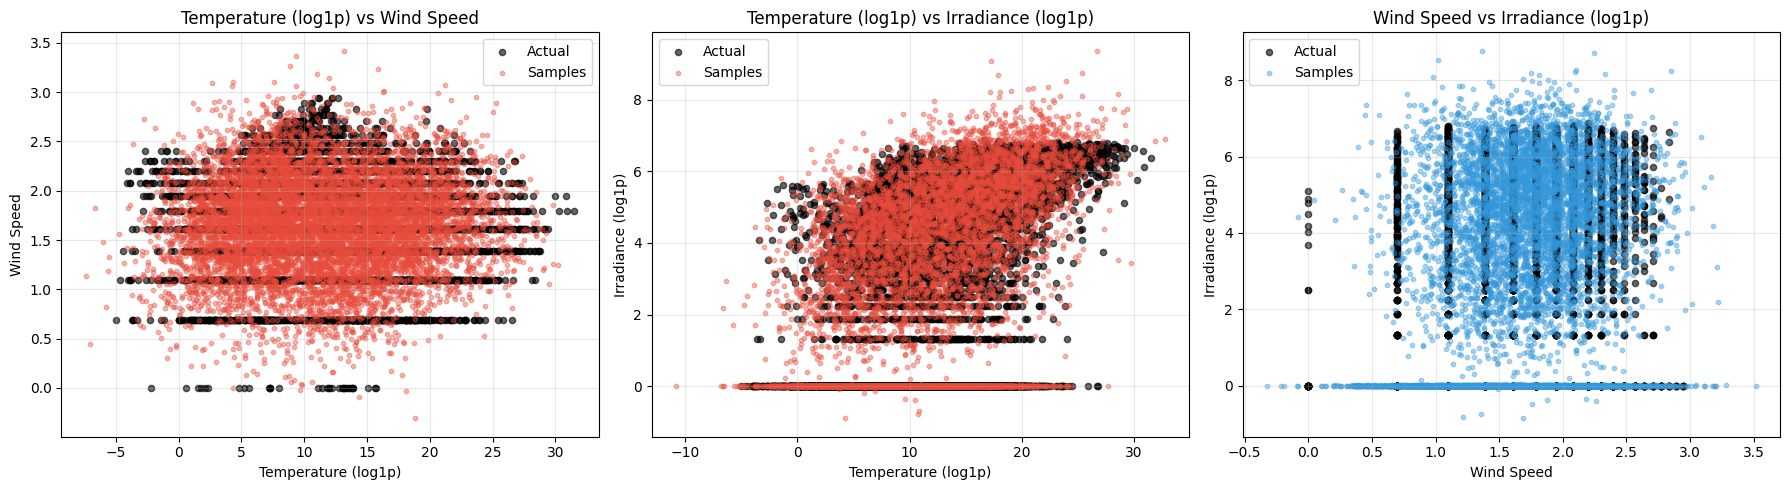

In [8]:
# Pairwise plots
pairs = [(0, 1), (0, 2), (1, 2)]
pair_names = [('Temperature (log1p)', 'Wind Speed'), ('Temperature (log1p)', 'Irradiance (log1p)'), ('Wind Speed', 'Irradiance (log1p)')]
pair_colors = [(colors['temp'], colors['wind']), (colors['temp'], colors['light']), (colors['wind'], colors['light'])]

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for i, ((i1, i2), (name1, name2), (color1, color2)) in enumerate(zip(pairs, pair_names, pair_colors)):
    ax = axes[i]
    
    # Actual data
    ax.scatter(y_2024[:, i1], y_2024[:, i2], alpha=0.6, s=20, c='black', label='Actual')
    
    # Random subsample to match actual data count
    n_actual = len(y_2024)
    n_samples_subset = min(len(samples_flat), n_actual)
    sample_indices = np.random.choice(len(samples_flat), n_samples_subset, replace=False)
    samples_subset = samples_flat[sample_indices]
    
    ax.scatter(samples_subset[:, i1], samples_subset[:, i2], alpha=0.4, s=10, c=color1, label='Samples')
    
    ax.set_xlabel(name1)
    ax.set_ylabel(name2)
    ax.set_title(f'{name1} vs {name2}')
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


## Daily Model with Annual Cycles


In [9]:
# Compute daily averages in original units first
daily = df.groupby(df.index.date).agg({
    'temp_c': 'mean',
    'wind_ms': 'mean', 
    'ghi_wm2': 'mean',
    'annual_sin': 'first',
    'annual_cos': 'first'
}).dropna()

daily.index = pd.to_datetime(daily.index)
daily['day_of_year'] = daily.index.dayofyear

# Apply log1p transformation to daily averages
daily['wind_ms_log1p'] = np.log1p(daily['wind_ms'])
daily['ghi_wm2_log1p'] = np.log1p(daily['ghi_wm2'])

# Prepare daily data - train on log1p transformed wind and light
X_daily = daily[['annual_sin', 'annual_cos']].values
y_daily = daily[['temp_c', 'wind_ms_log1p', 'ghi_wm2_log1p']].values

print(f"Daily data: {len(daily)} days from {daily.index.min()} to {daily.index.max()}")


Daily data: 4018 days from 2014-01-01 00:00:00 to 2024-12-31 00:00:00


In [15]:
# Fit daily model
model_daily = ConditionalGMMRegressor(n_components=8, random_state=42)
model_daily.fit(X_daily, y_daily)
print(f"Daily model fitted: {model_daily.n_components} components")


Daily model fitted: 8 components


## Daily Predictions and Plots (2023-2024)


In [16]:
# Get 2023-2024 daily data
mask_daily = (daily.index.year >= 2023) & (daily.index.year <= 2024)
daily_plot = daily[mask_daily].copy()
X_daily_plot = X_daily[mask_daily]
y_daily_plot = y_daily[mask_daily]

# Generate daily samples
samples_daily = model_daily.sample(X_daily_plot, n_samples=n_samples)

# Transform samples back to original units
samples_daily[:,:,1] = np.exp(samples_daily[:,:,1]) - 1  # wind_ms
samples_daily[:,:,2] = np.exp(samples_daily[:,:,2]) - 1  # ghi_wm2

percentiles_daily = np.percentile(samples_daily, [5, 50, 95], axis=1)
p5_d, p50_d, p95_d = percentiles_daily[0], percentiles_daily[1], percentiles_daily[2]

print(f"Daily samples: {samples_daily.shape[1]} samples for {len(daily_plot)} days")


Daily samples: 1000 samples for 731 days


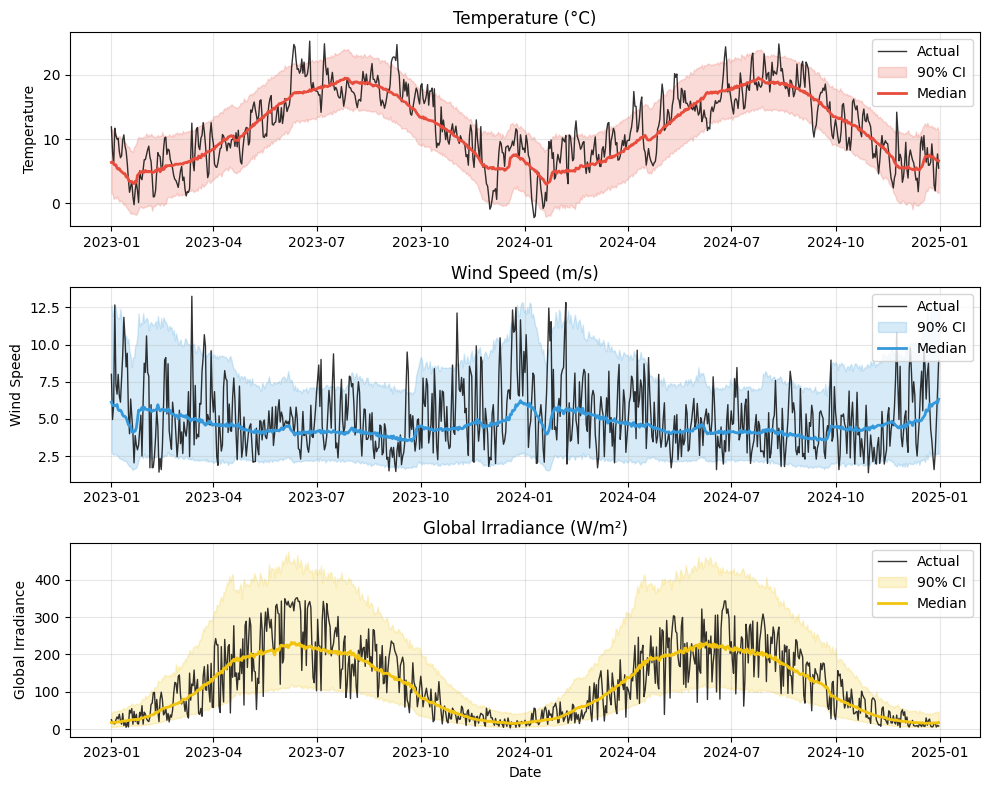

In [56]:
# Plot daily predictions
fig, axes = plt.subplots(3, 1, figsize=(10, 8))
variables_daily = ['temp_c', 'wind_ms', 'ghi_wm2']
titles_daily = ['Temperature (°C)', 'Wind Speed (m/s)', 'Global Irradiance (W/m²)']

for i, (var, title, color) in enumerate(zip(variables_daily, titles_daily, var_colors)):
    ax = axes[i]
    
    # Actual data
    ax.plot(daily_plot.index, daily_plot[var], 'k-', alpha=0.8, linewidth=1, label='Actual')
    
    # Model percentiles
    ax.fill_between(daily_plot.index, p5_d[:, i], p95_d[:, i], alpha=0.2, color=color, label='90% CI')
    ax.plot(daily_plot.index, p50_d[:, i], '-', color=color, linewidth=2, label='Median')
    
    ax.set_title(title)
    ax.set_ylabel(title.split('(')[0].strip())
    ax.legend(loc='upper right')
    ax.grid(True, alpha=0.3)
    
    if i == 2:
        ax.set_xlabel('Date')

plt.tight_layout()
plt.savefig('gallery_images/weather_daily.png', dpi=150, bbox_inches='tight')
plt.show()


## Daily Pairwise Distributions (2024)


In [57]:
# Get 2024 daily data
mask_daily_2024 = daily.index.year == 2024
daily_2024 = daily[mask_daily_2024]
X_daily_2024 = X_daily[mask_daily_2024]
y_daily_2024 = y_daily[mask_daily_2024]

# Generate daily samples for 2024
samples_daily_2024 = model_daily.sample(X_daily_2024, n_samples=n_samples)

# Transform samples back to original units
samples_daily_2024[:,:,1] = np.exp(samples_daily_2024[:,:,1]) - 1  # wind_ms
samples_daily_2024[:,:,2] = np.exp(samples_daily_2024[:,:,2]) - 1  # ghi_wm2

samples_daily_flat = samples_daily_2024.reshape(-1, 3)

print(f"2024 daily data: {len(daily_2024)} days, {samples_daily_flat.shape[0]} samples")


2024 daily data: 366 days, 366000 samples


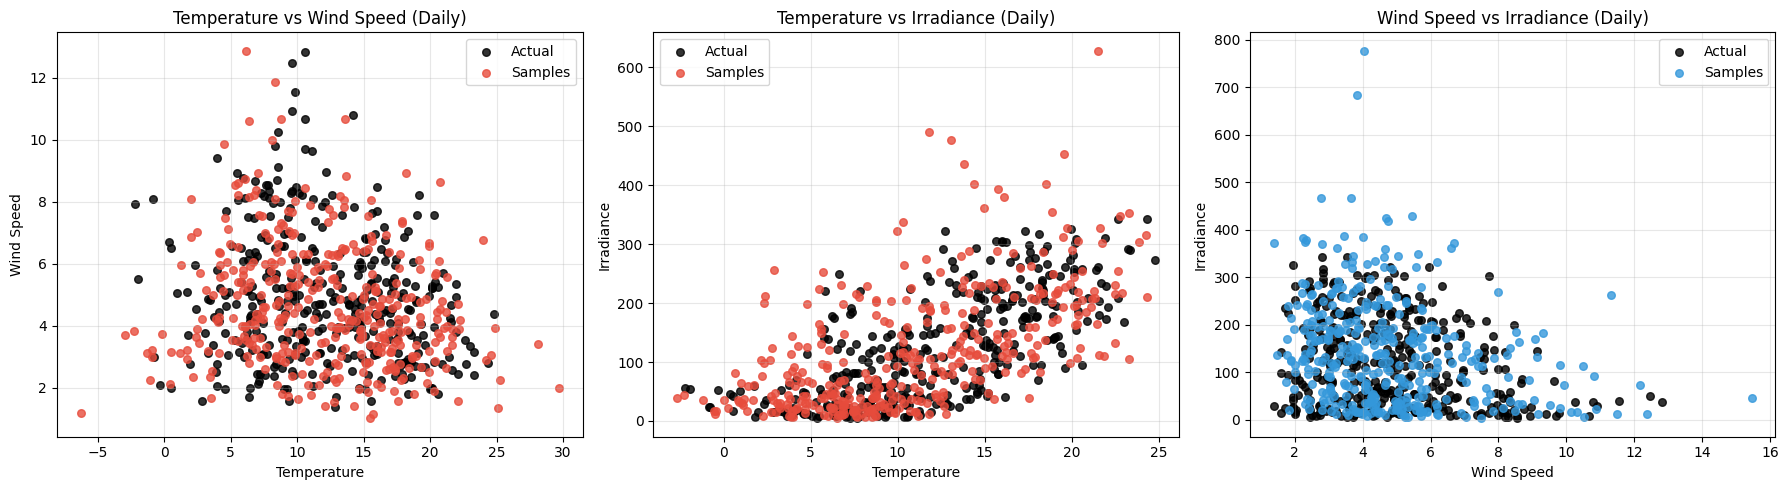

In [58]:
# Daily pairwise plots
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
pairs_daily = [(0, 1), (0, 2), (1, 2)]
pair_names_daily = [('Temperature', 'Wind Speed'), ('Temperature', 'Irradiance'), ('Wind Speed', 'Irradiance')]

for i, ((i1, i2), (name1, name2), (color1, color2)) in enumerate(zip(pairs_daily, pair_names_daily, pair_colors)):
    ax = axes[i]
    
    # Actual data - use original units
    actual_temp = daily_2024['temp_c'].values
    actual_wind = daily_2024['wind_ms'].values
    actual_light = daily_2024['ghi_wm2'].values
    actual_data = np.column_stack([actual_temp, actual_wind, actual_light])
    
    ax.scatter(actual_data[:, i1], actual_data[:, i2], alpha=0.8, s=30, c='black', label='Actual')
    
    # Random subsample to match actual data count
    n_actual_daily = len(actual_data)
    n_samples_daily_subset = min(len(samples_daily_flat), n_actual_daily)
    sample_indices_daily = np.random.choice(len(samples_daily_flat), n_samples_daily_subset, replace=False)
    samples_daily_subset = samples_daily_flat[sample_indices_daily]
    
    ax.scatter(samples_daily_subset[:, i1], samples_daily_subset[:, i2], alpha=0.8, s=30, c=color1, label='Samples')
    
    ax.set_xlabel(name1)
    ax.set_ylabel(name2)
    ax.set_title(f'{name1} vs {name2} (Daily)')
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


## 2D PDF Iso-lines Plot: Temperature vs Irradiance


In [59]:
from scipy.stats import gaussian_kde

# Extract temperature and irradiance from samples (already in original units)
temp_samples = samples_daily_flat[:, 0]  # Temperature
irrad_samples = samples_daily_flat[:, 2]  # Irradiance

# Create KDE from samples
kde_data = np.column_stack([temp_samples, irrad_samples])
kde = gaussian_kde(kde_data.T)

# Create 2D grid
temp_min, temp_max = daily_2024['temp_c'].min(), daily_2024['temp_c'].max()
irrad_min, irrad_max = daily_2024['ghi_wm2'].min(), daily_2024['ghi_wm2'].max()

temp_min, temp_max = -5, 25
irrad_min, irrad_max = 0, 400

temp_range = np.linspace(temp_min, temp_max, 100)
irrad_range = np.linspace(irrad_min, irrad_max, 100)
T_grid, I_grid = np.meshgrid(temp_range, irrad_range)

# Evaluate KDE on grid
grid_points = np.column_stack([T_grid.ravel(), I_grid.ravel()])
pdf_values = kde(grid_points.T).reshape(T_grid.shape)

print(f"KDE created from {len(samples_daily_flat):,} samples")
print(f"Grid: {T_grid.shape[0]}x{T_grid.shape[1]} points")


KDE created from 366,000 samples
Grid: 100x100 points


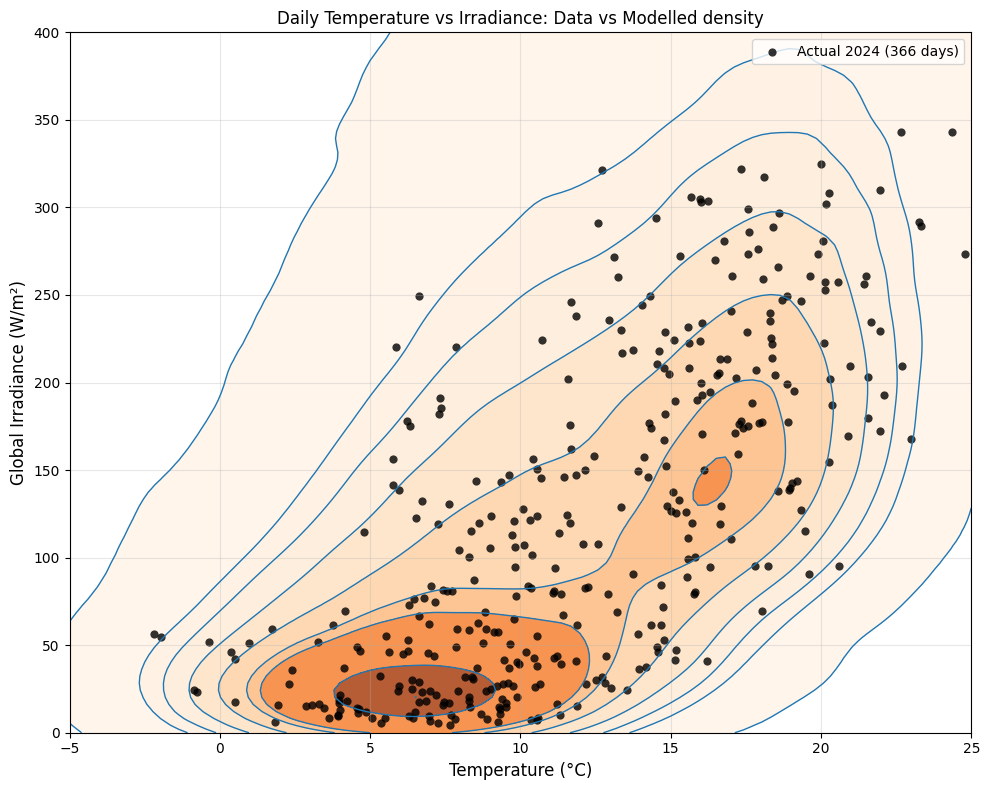

In [78]:
# Create 2D PDF plot with blue-red color scheme
fig, ax = plt.subplots(1, 1, figsize=(10, 8))

# Plot KDE iso-lines with blue-red colormap
levels = np.percentile(pdf_values, [20, 50, 60, 70, 80, 90, 95, 99, 99.999])
contour = ax.contour(T_grid, I_grid, pdf_values, levels=levels, colors='C0', 
                    alpha=1, linewidths=1)
contourf = ax.contourf(T_grid, I_grid, pdf_values, levels=levels, 
                      cmap='Oranges', alpha=0.8)

# Overlay actual 2024 data
actual_temp = daily_2024['temp_c'].values
actual_irrad = daily_2024['ghi_wm2'].values
ax.scatter(actual_temp, actual_irrad, alpha=0.8, s=35, c='k', 
          label=f'Actual 2024 ({len(actual_temp)} days)', edgecolors='white', linewidth=0.)


# Styling
ax.set_xlabel('Temperature (°C)', fontsize=12)
ax.set_ylabel('Global Irradiance (W/m²)', fontsize=12)
ax.set_title('Daily Temperature vs Irradiance: Data vs Modelled density')
ax.legend(loc='upper right')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('gallery_images/weather_ti_density.png', dpi=150, bbox_inches='tight')

plt.show()


## Create Animated GIF Gallery


In [80]:
from PIL import Image

# Create animated GIF from saved images
def create_animated_gif(image_folder, output_path, duration=2000, loop=0):
    """
    Create an animated GIF from images in a folder.
    
    Parameters:
    - image_folder: Path to folder containing images
    - output_path: Path for output GIF file
    - duration: Duration of each frame in milliseconds
    - loop: Number of loops (0 = infinite)
    """
    # Get all PNG files and sort them
    image_files = [f for f in os.listdir(image_folder) if f.endswith('.png')]
    image_files.sort()
    
    if not image_files:
        print("No PNG files found in the folder!")
        return
    
    # Load images
    images = []
    for filename in image_files:
        filepath = os.path.join(image_folder, filename)
        img = Image.open(filepath)
        images.append(img)
    
    print(f"Creating animated GIF from {len(images)} images...")
    print(f"Images: {', '.join(image_files)}")
    
    # Create animated GIF
    images[0].save(
        output_path,
        save_all=True,
        append_images=images[1:],
        duration=duration,
        loop=loop,
        optimize=True
    )
    
    print(f"✓ Animated GIF saved: {output_path}")
    return output_path

# Create the animated GIF
gif_path = create_animated_gif(
    image_folder='gallery_images',
    output_path='amsterdam_weather_gallery.gif',
    duration=1500,  # 3 seconds per image
    loop=0  # Infinite loop
)


Creating animated GIF from 3 images...
Images: weather_daily.png, weather_hourly.png, weather_ti_density.png
✓ Animated GIF saved: amsterdam_weather_gallery.gif


## Summary

**Models fitted:**
- Hourly: 8-component conditional GMM with daily + annual cycles
- Daily: 8-component conditional GMM with annual cycles only

**Key insights:**
- Models capture seasonal and daily patterns well
- Uncertainty bands show model confidence
- Pairwise plots reveal correlations between weather variables
- Daily model smooths out hourly noise while preserving seasonal trends
